In [115]:
# Task 3 - DBSCAN
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd

# reading in the data 
df = pd.read_csv('data_all.csv')

# extracting relevant columns 
phi_psi = df.iloc[:, 3:5].values.reshape(-1,2)

# translating negative angles to positive equivalent
phi_psi_positive = phi_psi%360

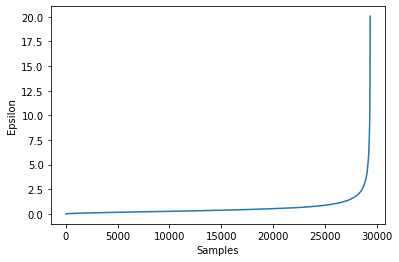

In [116]:
# calculate optimal value of epsilon with distance to nearest neighbour
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(phi_psi_positive)
distances, indices = nbrs.kneighbors(phi_psi_positive)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel('Samples')
plt.ylabel('Epsilon')
plt.plot(distances)

In [117]:
# silhouette score for different epsilon and fixed min_samples
range_eps = [19, 20, 21, 22]
for i in range_eps:
    print("Epsilon value is "+ str(i))
    db = DBSCAN(eps=i, min_samples=40).fit(phi_psi_positive)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    print(set(labels))
    silhouette_avg = silhouette_score(phi_psi_positive, labels)
    print("For epsilon value= "+str(i),
         "The silhouette score is :", silhouette_avg)

Epsilon value is 19
{0, 1, 2, 3, 4, -1}
For epsilon value= 19 The silhouette score is : 0.6746186846456379
Epsilon value is 20
{0, 1, 2, 3, 4, -1}
For epsilon value= 20 The silhouette score is : 0.675804990335106
Epsilon value is 21
{0, 1, 2, -1}
For epsilon value= 21 The silhouette score is : 0.37062307792713217
Epsilon value is 22
{0, 1, 2, -1}
For epsilon value= 22 The silhouette score is : 0.37626985594900575


In [118]:
# silhouette score for fixed epsilon and different min_samples
min_samples = [39, 40, 41]
for i in min_samples:
    print("min_samples value is "+ str(i))
    db = DBSCAN(eps=20, min_samples=i).fit(phi_psi_positive)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    print(set(labels))
    silhouette_avg = silhouette_score(phi_psi_positive, labels)
    print("For min_samples value= "+str(i),
         "The average silhouette score is :", silhouette_avg)

min_samples value is 39
{0, 1, 2, 3, -1}
For min_samples value= 39 The average silhouette score is : 0.6686268463841407
min_samples value is 40
{0, 1, 2, 3, 4, -1}
For min_samples value= 40 The average silhouette score is : 0.675804990335106
min_samples value is 41
{0, 1, 2, 3, 4, -1}
For min_samples value= 41 The average silhouette score is : 0.6755692825276002


Estimated number of clusters: 5
Estimated number of noise points: 243


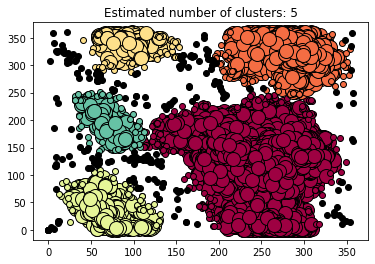

The silhouette score: 0.675804990335106


In [119]:
# DBSCAN on main dataset
db = DBSCAN(eps=20, min_samples=40).fit(phi_psi_positive)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# plotting - black removed and is used for noise instead
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = phi_psi_positive[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = phi_psi_positive[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# silhouette score for main dataset
silhouette_main = silhouette_score(phi_psi_positive, labels)
print(f"The silhouette score: {silhouette_main}")

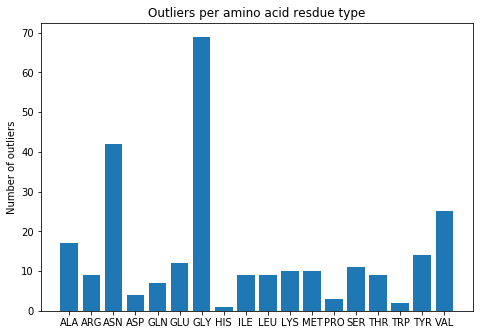

In [120]:
# dataframe for outliers
df_outlier_values = pd.DataFrame(xy)
df_temp = df_outlier_values.rename(columns={0:'phi', 1:'psi'})
df[['phi','psi']] = df[['phi', 'psi']]%360
df_outliers = pd.merge(df_temp, df, on=['phi', 'psi'])

# summing together freq. for the different residue types
occurence = df_outliers.pivot_table(index=['residue name'], aggfunc='size')

index = np.arange(len(occurence))

# plotting bar chart
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(index, occurence)
plt.xticks(index, occurence.index)
plt.ylabel('Number of outliers')
plt.title('Outliers per amino acid resdue type')
plt.show()

Estimated number of clusters: 5
Estimated number of noise points: 229


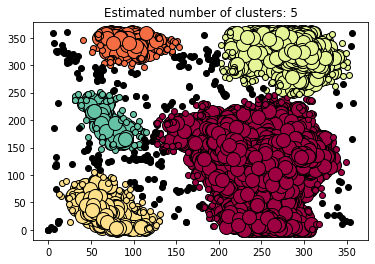

The silhouette score: 0.6748692972951911


In [121]:
# validation - stability on subsets
# removing a random 20% av the data
np.random.seed(0)

fraction = 0.2
remove_n = int(fraction * int(len(df.index)))
drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)

# extracting relevant columns 
phi_psi_positive_subset = df_subset.iloc[:, 3:5].values.reshape(-1,2)%360

# DBSCAN on subset
db = DBSCAN(eps=20, min_samples=40).fit(phi_psi_positive_subset)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

# plotting - black removed and is used for noise instead
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy1 = phi_psi_positive_subset[class_member_mask & core_samples_mask]
    plt.plot(xy1[:, 0], xy1[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy2 = phi_psi_positive_subset[class_member_mask & ~core_samples_mask]
    plt.plot(xy2[:, 0], xy2[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# silhouette score for subset 
silhouette_subset = silhouette_score(phi_psi_positive_subset, labels)
print(f"The silhouette score: {silhouette_subset}")